In [3]:
!pip install textblob


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   - -------------------------------------- 30.7/624.3 kB 1.3 MB/s eta 0:00:01
   --------- ------------------------------ 143.4/624.3 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 624.3/624.3 kB 4.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load data
df = pd.read_csv(r'C:\Users\Asus\Desktop\AIDI2ndSemester\AI infra\scrapedData.csv')

# Check for missing values
print("Missing values:")
print(df.isna().sum())

# Drop rows with NaN in 'category' (labels)
df = df.dropna(subset=['category'])
df['clean_text'] = df['clean_text'].fillna('')  # Fill empty texts

# Text preprocessing
def preprocess_text(text):
    text = str(text).lower()  # Convert to string and lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    
    # Tokenize and remove stopwords
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

df['processed_text'] = df['clean_text'].apply(preprocess_text)

Missing values:
clean_text    4
category      7
dtype: int64


In [21]:
from textblob import TextBlob

def textblob_sentiment(text, pos_thresh=0.1, neg_thresh=-0.1):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > pos_thresh:
        return 1  # Positive
    elif polarity < neg_thresh:
        return -1  # Negative
    else:
        return 0  # Neutral

df['textblob_pred'] = df['processed_text'].apply(textblob_sentiment)

# Evaluate
from sklearn.metrics import classification_report, accuracy_score
print("TextBlob Performance:")
print(classification_report(df['category'], df['textblob_pred']))
print(f"Accuracy: {accuracy_score(df['category'], df['textblob_pred']):.2f}")

TextBlob Performance:
              precision    recall  f1-score   support

        -1.0       0.91      0.65      0.76     35510
         0.0       0.66      0.98      0.79     55213
         1.0       0.97      0.75      0.85     72250

    accuracy                           0.81    162973
   macro avg       0.85      0.79      0.80    162973
weighted avg       0.85      0.81      0.81    162973

Accuracy: 0.81


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Split data
X = df['processed_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression())
])

# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("\nLogistic Regression Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

C:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Performance:
              precision    recall  f1-score   support

        -1.0       0.87      0.76      0.81      7230
         0.0       0.85      0.96      0.90     10961
         1.0       0.92      0.88      0.90     14404

    accuracy                           0.88     32595
   macro avg       0.88      0.87      0.87     32595
weighted avg       0.88      0.88      0.88     32595

Accuracy: 0.88


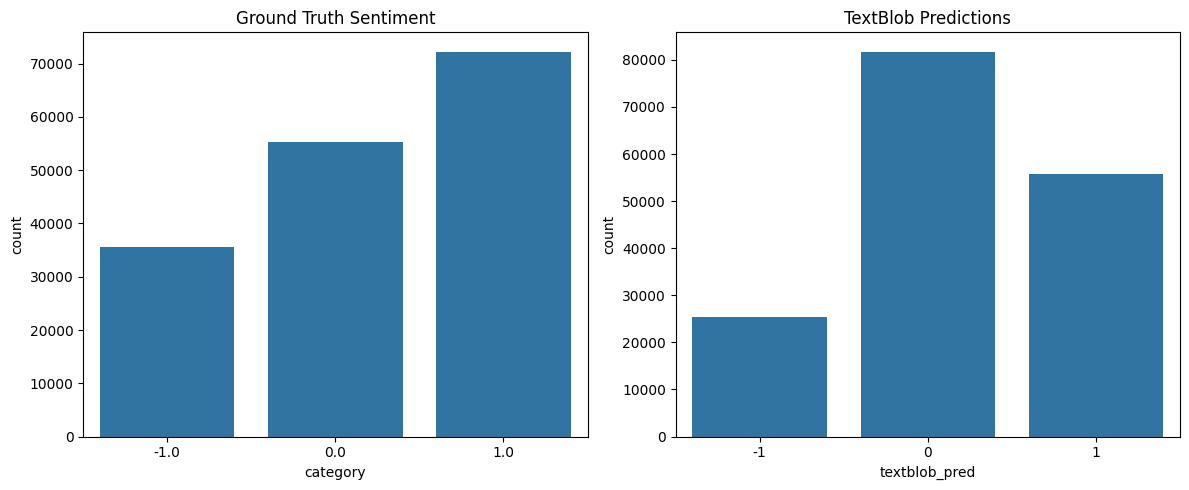

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot ground truth vs TextBlob predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='category', data=df, ax=axes[0])
axes[0].set_title('Ground Truth Sentiment')

sns.countplot(x='textblob_pred', data=df, ax=axes[1])
axes[1].set_title('TextBlob Predictions')

plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

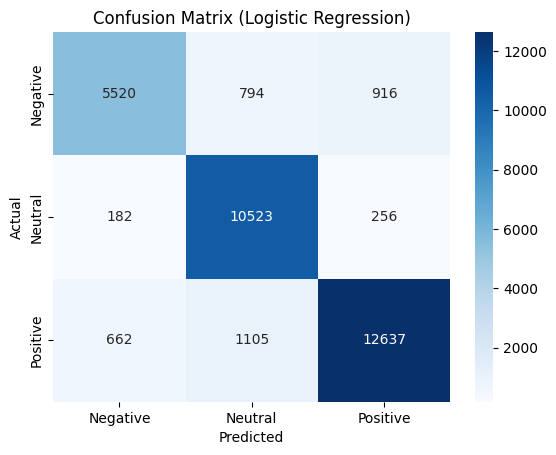

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
!pip install wordcloud


   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/299.9 kB 991.0 kB/s eta 0:00:01
   --------------------------- ------------ 204.8/299.9 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 2.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


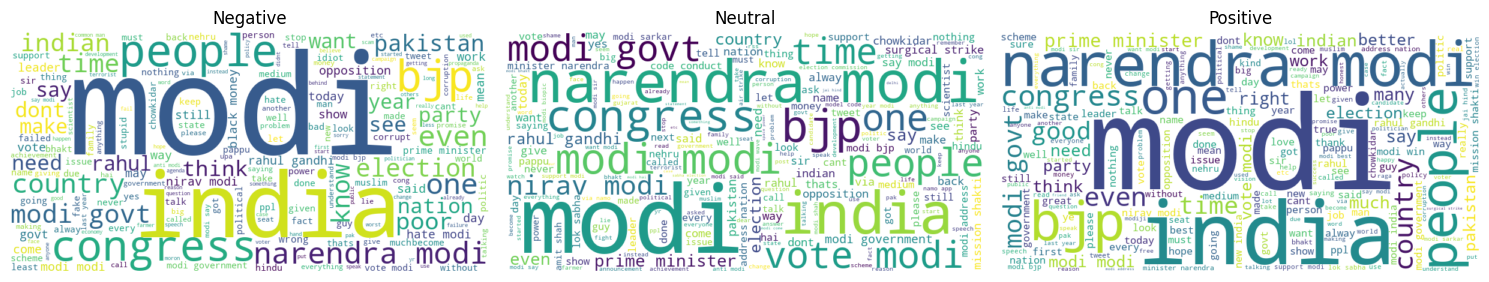

In [27]:
from wordcloud import WordCloud

sentiments = ['Negative', 'Neutral', 'Positive']
plt.figure(figsize=(15, 5))

for i, sentiment in enumerate([-1, 0, 1]):
    text = ' '.join(df[df['category'] == sentiment]['processed_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(sentiments[i])
    plt.axis('off')

plt.tight_layout()
plt.savefig('wordclouds.png')
plt.show()

Couldn't load mask image for Negative, using default shape
Couldn't load mask image for Neutral, using default shape
Couldn't load mask image for Positive, using default shape


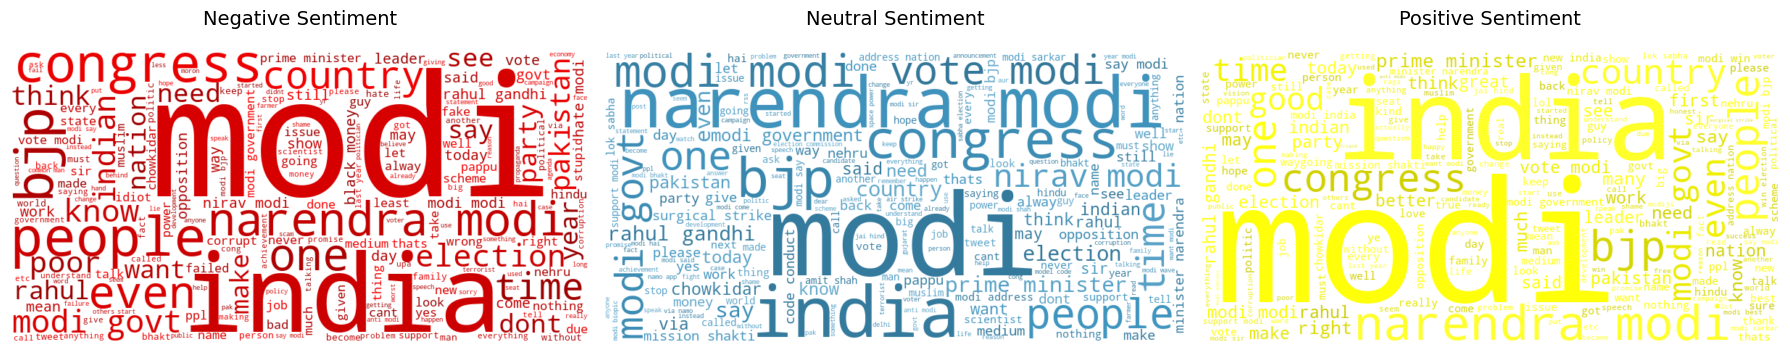

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

# Sample mask images (replace with your own image paths)
MASK_PATHS = {
    -1: "cloud_mask.png",  # Negative sentiment (e.g., storm cloud)
    0: "circle_mask.png",  # Neutral sentiment (e.g., circle)
    1: "sun_mask.png"      # Positive sentiment (e.g., sun)
}

# Custom color functions for each sentiment
def negative_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 100%%, %d%%)" % np.random.randint(30, 50)  # Dark red shades

def neutral_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(200, 50%%, %d%%)" % np.random.randint(40, 60)  # Blue-gray shades

def positive_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(60, 100%%, %d%%)" % np.random.randint(40, 60)  # Gold/yellow shades

# Create a figure with 3 subplots
plt.figure(figsize=(18, 6))

for i, (sentiment_val, sentiment_name) in enumerate(zip([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])):
    # Get text for this sentiment
    text = ' '.join(df[df['category'] == sentiment_val]['processed_text'])
    
    # Create custom mask if available
    mask = None
    try:
        if MASK_PATHS.get(sentiment_val):
            mask = np.array(Image.open(MASK_PATHS[sentiment_val]))
    except:
        print(f"Couldn't load mask image for {sentiment_name}, using default shape")
    
    # Generate word cloud with sentiment-specific settings
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        mask=mask,
        max_words=200,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)
    
    # Apply sentiment-specific coloring
    if sentiment_val == -1:
        wc.recolor(color_func=negative_color_func)
    elif sentiment_val == 0:
        wc.recolor(color_func=neutral_color_func)
    else:
        wc.recolor(color_func=positive_color_func)
    
    # Create subplot
    plt.subplot(1, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"{sentiment_name} Sentiment", fontsize=14, pad=20)
    plt.axis('off')
    
    # Save individual word clouds
    wc.to_file(f"wordcloud_{sentiment_name.lower()}.png")

plt.tight_layout()
plt.savefig('combined_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()

Saved Negative word cloud to wordcloud_negative.png


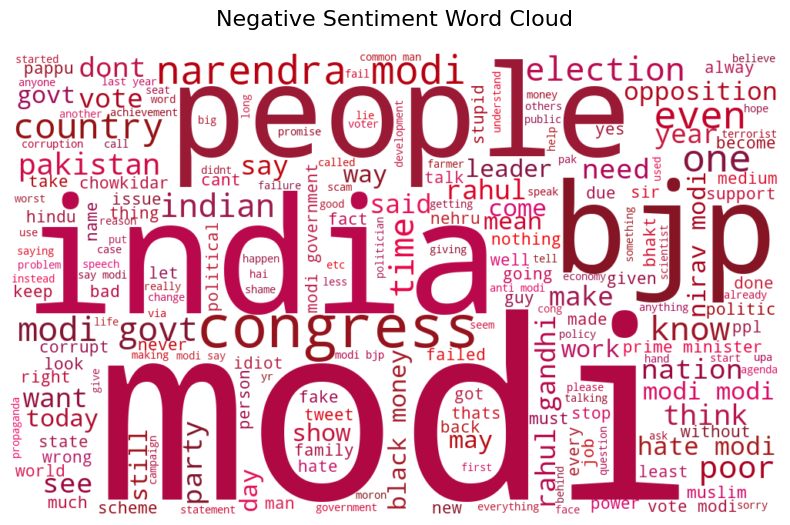

Saved Neutral word cloud to wordcloud_neutral.png


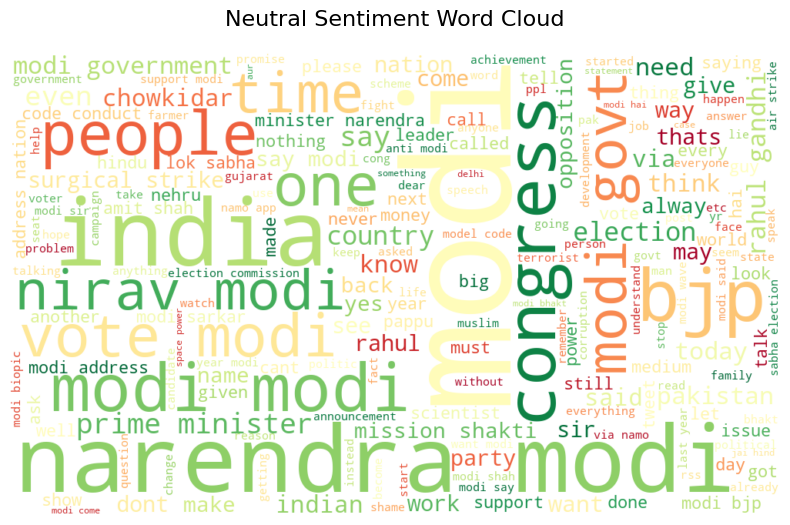

Saved Positive word cloud to wordcloud_positive.png


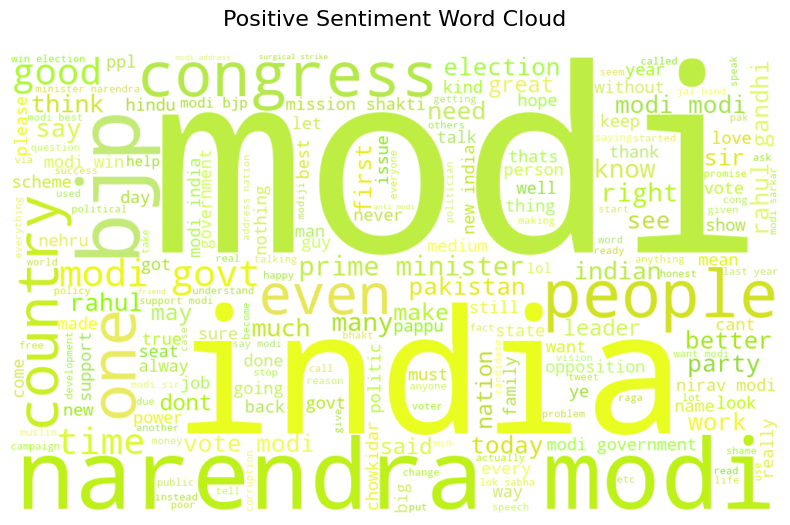

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Custom color functions for each sentiment
def negative_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """Dark red/purple shades for negative sentiment"""
    return f"hsl({np.random.randint(330, 360)}, {np.random.randint(70, 100)}%, {np.random.randint(30, 50)}%)"

def neutral_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """Blue/gray shades for neutral sentiment"""
    return f"hsl({np.random.randint(200, 220)}, {np.random.randint(40, 60)}%, {np.random.randint(50, 70)}%)"

def positive_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    """Bright yellow/green shades for positive sentiment"""
    return f"hsl({np.random.randint(60, 90)}, {np.random.randint(70, 100)}%, {np.random.randint(50, 70)}%)"

# Generate separate figures for each sentiment
for sentiment_val, sentiment_name in zip([-1, 0, 1], ['Negative', 'Neutral', 'Positive']):
    # Create a new figure for this sentiment
    plt.figure(figsize=(10, 6))
    
    # Get text for this sentiment
    text = ' '.join(df[df['category'] == sentiment_val]['processed_text'])
    
    # Generate word cloud with sentiment-specific settings
    wc = WordCloud(
        width=1000,
        height=600,
        background_color='white',
        max_words=200,
        colormap='RdYlGn' if sentiment_val == 0 else None  # Only use colormap for neutral
    ).generate(text)
    
    # Apply sentiment-specific coloring
    if sentiment_val == -1:
        wc.recolor(color_func=negative_color_func)
    elif sentiment_val == 0:
        # Neutral keeps the RdYlGn colormap
        pass  
    else:
        wc.recolor(color_func=positive_color_func)
    
    # Display the word cloud
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"{sentiment_name} Sentiment Word Cloud", fontsize=16, pad=20)
    plt.axis('off')
    
    # Save individual word clouds
    output_path = f"wordcloud_{sentiment_name.lower()}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Saved {sentiment_name} word cloud to {output_path}")
    
    # Show each figure separately
    plt.show()
    
    # Close the figure to free memory
    plt.close()